In [ ]:
from google.colab import drive
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN

In [ ]:
data = pd.read_csv('/content/drive/My Drive/DTU/Introduction to Business Analytics/project/Trips_2018_clean.csv')

In [ ]:
data.head()

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,...,gender,start_time,stop_time,tripduration_min,age
0,72.0,40.767272,-73.993929,505.0,40.749013,...,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26
1,72.0,40.767272,-73.993929,3255.0,40.750585,...,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49
2,72.0,40.767272,-73.993929,525.0,40.755942,...,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62
3,72.0,40.767272,-73.993929,447.0,40.763707,...,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44
4,72.0,40.767272,-73.993929,3356.0,40.774667,...,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26


In [ ]:
data["end_station_id"].value_counts()

,count
end_station_id,
519.0,149652
497.0,113099
402.0,108873
435.0,108457
426.0,99048
...,...
3191.0,1
3428.0,1
3279.0,1


In [ ]:
start_ids = set(data['start_station_id'].unique())
end_ids = set(data['end_station_id'].unique())

In [ ]:
only_start = start_ids - end_ids
only_end = end_ids - start_ids


In [ ]:
print(f"Total start stations: {len(start_ids)}")
print(f"Total end stations: {len(end_ids)}")
print(f"Stations only in start: {len(only_start)}")
print(f"Stations only in end: {len(only_end)}")

print("\nStations only in start:", only_start)
print("Stations only in end:", only_end)


Total start stations: 816
Total end stations: 843
Stations only in start: 0
Stations only in end: 27

Stations only in start: set()
Stations only in end: {np.float64(3202.0), np.float64(3203.0), np.float64(3213.0), np.float64(3214.0), np.float64(3481.0), np.float64(3639.0), np.float64(3267.0), np.float64(3268.0), np.float64(3270.0), np.float64(3275.0), np.float64(3276.0), np.float64(3277.0), np.float64(3279.0), np.float64(3678.0), np.float64(3681.0), np.float64(3428.0), np.float64(3183.0), np.float64(3184.0), np.float64(3185.0), np.float64(3186.0), np.float64(3187.0), np.float64(3191.0), np.float64(3192.0), np.float64(3195.0), np.float64(3196.0), np.float64(3198.0), np.float64(3199.0)}


In [ ]:
stations_start = (data[["start_station_id","start_station_latitude","start_station_longitude"]]
                  .rename(columns={"start_station_id":"station_id",
                                   "start_station_latitude":"lat",
                                   "start_station_longitude":"lon"}))

In [ ]:
stations_end = (data[["end_station_id","end_station_latitude","end_station_longitude"]]
                .rename(columns={"end_station_id":"station_id",
                                 "end_station_latitude":"lat",
                                 "end_station_longitude":"lon"}))

In [ ]:
stations = (pd.concat([stations_start, stations_end], ignore_index=True)
              .groupby("station_id", as_index=False)
              .agg(lat=("lat","median"), lon=("lon","median")))

In [ ]:
stations

,station_id,lat,lon
0,72.0,40.767272,-73.993929
1,79.0,40.719116,-74.006667
2,82.0,40.711174,-74.000165
3,83.0,40.683826,-73.976323
4,119.0,40.696089,-73.978034
...,...,...,...
838,3716.0,40.753599,-73.937956
839,3718.0,40.727464,-73.979504
840,3719.0,40.683223,-73.973812
841,3720.0,40.684617,-73.987213


In [ ]:
stations.shape

(843, 3)

-------------------------------------------------------------
#CLUSTERING
-------------------------------------------------------------

In [ ]:
station_test = stations.copy()

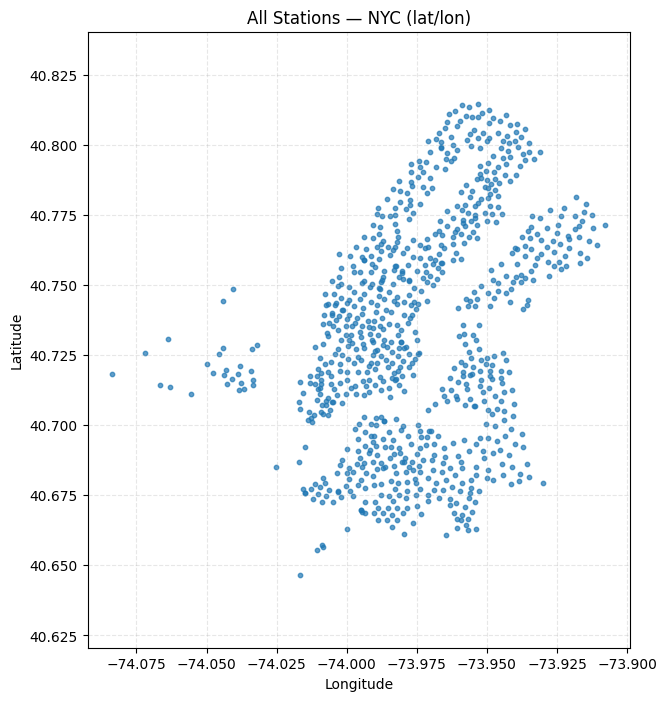

In [ ]:
plt.figure(figsize=(7, 8))
plt.scatter(
    station_test['lon'],
    station_test['lat'],
    s=10, alpha=0.7
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('All Stations — NYC (lat/lon)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')
plt.show()

In [ ]:
import folium

m = folium.Map(
    location=[station_test['lat'].mean(), station_test['lon'].mean()],
    zoom_start=11, tiles='cartodbpositron'
)
for _, r in station_test.iterrows():
    folium.CircleMarker([r['lat'], r['lon']], radius=2, fill=True, fill_opacity=0.7).add_to(m)
m.save("nyc_stations.html")
print("Saved nyc_stations.html")


Saved nyc_stations.html


In [ ]:
#MAIN FUNCTION FOR DBSCAN
# df: columns ['station_id','latitude','longitude']
coords_deg = station_test[['lat','lon']].to_numpy()
coords_rad = np.radians(coords_deg)

#neighborhood in meters!!!
eps_m = 222
eps_rad = eps_m / 6371000.0

clu = DBSCAN(eps=eps_rad, min_samples=5, metric='haversine', algorithm='ball_tree').fit(coords_rad)
station_test['cluster'] = clu.labels_

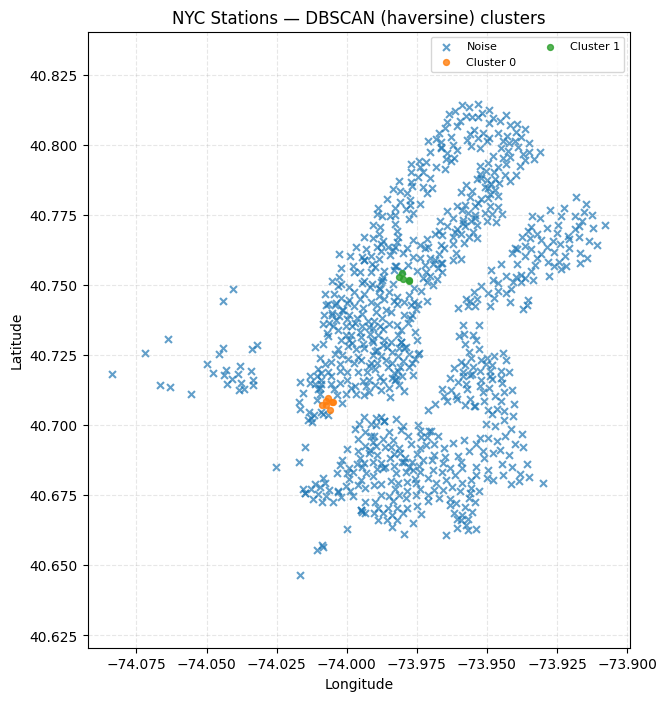

In [ ]:
# PLOTING CLUSTERS
labels = station_test['cluster'].to_numpy()
unique_labels = np.unique(labels)

plt.figure(figsize=(7, 8))

for lab in unique_labels:
    mask = labels == lab
    if lab == -1:
        # noise
        plt.scatter(
            station_test.loc[mask, 'lon'], station_test.loc[mask, 'lat'],
            marker='x', s=25, alpha=0.7, label='Noise'
        )
    else:
        plt.scatter(
            station_test.loc[mask, 'lon'], station_test.loc[mask, 'lat'],
            s=18, alpha=0.8, label=f'Cluster {lab}'
        )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NYC Stations — DBSCAN (haversine) clusters')
plt.legend(loc='best', fontsize=8, ncol=2)
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal')
plt.show()

In [ ]:
# SEE NUMBER OF NOISE POINTS
n_clusters = (station_test['cluster'] >= 0).sum() and station_test['cluster'][station_test['cluster']>=0].nunique()
n_noise = (station_test['cluster'] == -1).sum()
print("Clusters:", n_clusters, " Noise points:", n_noise)

# Cluster sizes
print(station_test[station_test['cluster']>=0]['cluster'].value_counts().sort_index())


Clusters: 12  Noise points: 111
cluster
0     369
1     155
2      56
3      17
4      14
5       8
6      34
7      13
8      13
9       6
10     15
11     32
Name: count, dtype: int64


In [ ]:
from sklearn.neighbors import NearestNeighbors

coords_rad = np.radians(station_test[['lat','lon']].to_numpy())
k = 6
nn = NearestNeighbors(n_neighbors=k, metric='haversine', algorithm='ball_tree').fit(coords_rad)
dists, _ = nn.kneighbors(coords_rad)
kth_m = np.sort(dists[:, -1] * 6_371_000)

print("k-distance percentiles [m]:", np.percentile(kth_m, [25,50,60,70,80,90]))
eps_m = float(np.percentile(kth_m, 60))
eps_rad = eps_m / 6_371_000


k-distance percentiles [m]: [355.5011854  407.68740947 428.61112538 462.79364268 496.54379281
 564.23777378]


NEXT ARE METRICS AND GRID SEARCH FOR FINDING BEST COMBINATION OF PARAMETERS

In [ ]:
from sklearn.metrics import silhouette_score

coords_rad = np.radians(station_test[['lat','lon']].to_numpy())
labels = station_test['cluster'].to_numpy()
mask = labels != -1
sil = silhouette_score(coords_rad[mask], labels[mask], metric='haversine')
print("Silhouette (haversine):", sil)


Silhouette (haversine): 0.2042935109139128


In [ ]:
R = 6_371_000.0
X_rad = np.radians(station_test[['lat','lon']].to_numpy())

def run_dbscan(eps_m, min_samples):
    labels = DBSCAN(eps=eps_m/R, min_samples=min_samples, metric='haversine',
                    algorithm='ball_tree').fit(X_rad).labels_
    return labels


k = 6
nn = NearestNeighbors(n_neighbors=k, metric='haversine').fit(X_rad)
dists, _ = nn.kneighbors(X_rad)
kth_m = np.sort(dists[:, -1] * R)
print("k-dist percentiles [m]:", np.percentile(kth_m, [25,50,60,70,80]))


candidates = []
for eps_m in range(260, 1000, 20):
    for ms in [3,4,5,6,7,8,9,10,12,14]:
        lab = run_dbscan(eps_m, ms)
        n_noise = np.sum(lab == -1)
        n_clust = len(set(lab) - {-1})
        noise_frac = n_noise / len(lab)
        if n_clust >= 20 and noise_frac <= 0.35:
            mask = lab != -1
            sil = silhouette_score(X_rad[mask], lab[mask], metric='haversine') if n_clust>1 else -1
            candidates.append((eps_m, ms, n_clust, noise_frac, sil))


candidates = sorted(candidates, key=lambda x: (-x[4], x[3], -x[2]))
print("Top candidates (eps_m, min_samples, clusters, noise_frac, silhouette):")
for row in candidates[:]:
    print(row)


if candidates:
    eps_m, ms, *_ = candidates[0]
    station_test['cluster'] = run_dbscan(eps_m, ms)
    print(f"Chosen: eps={eps_m} m, min_samples={ms}")


k-dist percentiles [m]: [355.5011854  407.68740947 428.61112538 462.79364268 496.54379281]
Top candidates (eps_m, min_samples, clusters, noise_frac, silhouette):
(300, 3, 62, np.float64(0.22301304863582444), np.float64(0.25124860433121715))
(420, 7, 25, np.float64(0.2775800711743772), np.float64(0.247170722151178))
(340, 5, 32, np.float64(0.3250296559905101), np.float64(0.23030157380466332))
(280, 3, 70, np.float64(0.33214709371293), np.float64(0.2223956054895586))
(320, 4, 39, np.float64(0.31316725978647686), np.float64(0.2135759508643415))
(460, 8, 23, np.float64(0.2669039145907473), np.float64(0.19810299902583178))
(480, 9, 21, np.float64(0.3036773428232503), np.float64(0.1849485753278359))
(400, 6, 26, np.float64(0.21708185053380782), np.float64(0.16344984661795398))
(380, 6, 28, np.float64(0.31791221826809013), np.float64(0.14855263920635456))
(360, 5, 29, np.float64(0.22419928825622776), np.float64(0.13878798365005138))
(380, 5, 26, np.float64(0.1506524317912218), np.float64(0.09

In [ ]:
def grid_search_dbscan(coords_rad, eps_values, min_samples_values):
    best_score = -1
    best_params = None
    best_labels = None

    for eps_m in eps_values:
        for min_samples in min_samples_values:

            eps_rad = eps_m / 6371000.0
            db = DBSCAN(eps=eps_rad, min_samples=min_samples, metric='haversine')
            labels = db.fit_predict(coords_rad)


            valid_labels = labels[labels != -1]


            if len(np.unique(valid_labels)) > 1:
                score = silhouette_score(coords_rad[labels != -1], valid_labels, metric='haversine')
                if score > best_score:
                    best_score = score
                    best_params = (eps_m, min_samples)
                    best_labels = labels

    return best_score, best_params, best_labels


eps_values = np.linspace(200, 600, 20)
min_samples_values = range(5, 11)


best_score, best_params, best_labels = grid_search_dbscan(coords_rad, eps_values, min_samples_values)
print(f"Best Silhouette score: {best_score}")
print(f"Best parameters: eps={best_params[0]}, min_samples={best_params[1]}")


station_test['cluster'] = best_labels

Best Silhouette score: 0.9569118816327751
Best parameters: eps=221.05263157894737, min_samples=5
